<a href="https://colab.research.google.com/github/Azamat0315277/pytorch_paper_replicating_for_computer_vision/blob/main/PyTorch_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup notebook

In [1]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split('.')[1]) >= 12
  assert int(torchvision.__version__.split('.')[1]) >= 13
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:
# import scripts
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo()
try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory
try:
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going_modular scripts
  print(f"[INFO] Couldn't find going_modular or helper_functions scripts")
  #!git clone https://github.com/mrdbourke/pytorch-deep-learning
  !git clone https://github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision

  !mv pytorch_paper_replicating_for_computer_vision/going_modular .
  !mv pytorch_paper_replicating_for_computer_vision/helper_functions.py . 
  !rm -rf pytorch_paper_replicating_for_computer_vision
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Get the Data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to  train and test set
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# Create DataSets and Dataloaders

## Prepare transforms for images

In [6]:
# Creata image size 
IMG_SIZE = 224

# create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created tranforms: {manual_transforms}")

Manually created tranforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


## Turn images into DataLoaders

In [7]:
BATCH_SIZE=32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f540ea990d0>,
 ['pizza', 'steak', 'sushi'])

## Visualize a single image

In [8]:
# get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get a single image from the batch
image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

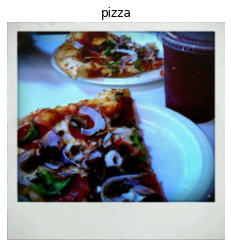

In [9]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label]) 
plt.axis(False);

# Replicating the ViT paper: an overview

## Calculating patch embedding input an doutput shapes by hand

In [10]:
# Create example values

height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)

number_of_patches = int((height * width) / patch_size**2)

In [11]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image: {embedding_layer_input_shape}')
print(f'Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}')

Input shape (single 2D image: (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


## Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

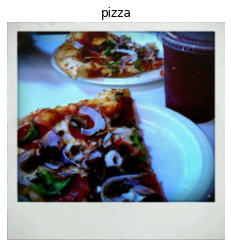

In [12]:
# View single image

plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

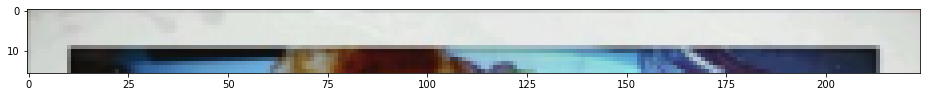

In [13]:
# Change image shape to be compatible with matplotlib

image_permuted = image.permute(1, 2, 0)

# Index to plot the top of patched pixels
patch_size = 16 
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


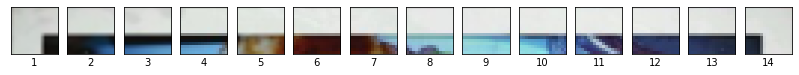

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible

img_size = 224
patch_size = 16

num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)
# Iterate through number of patches in the top
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


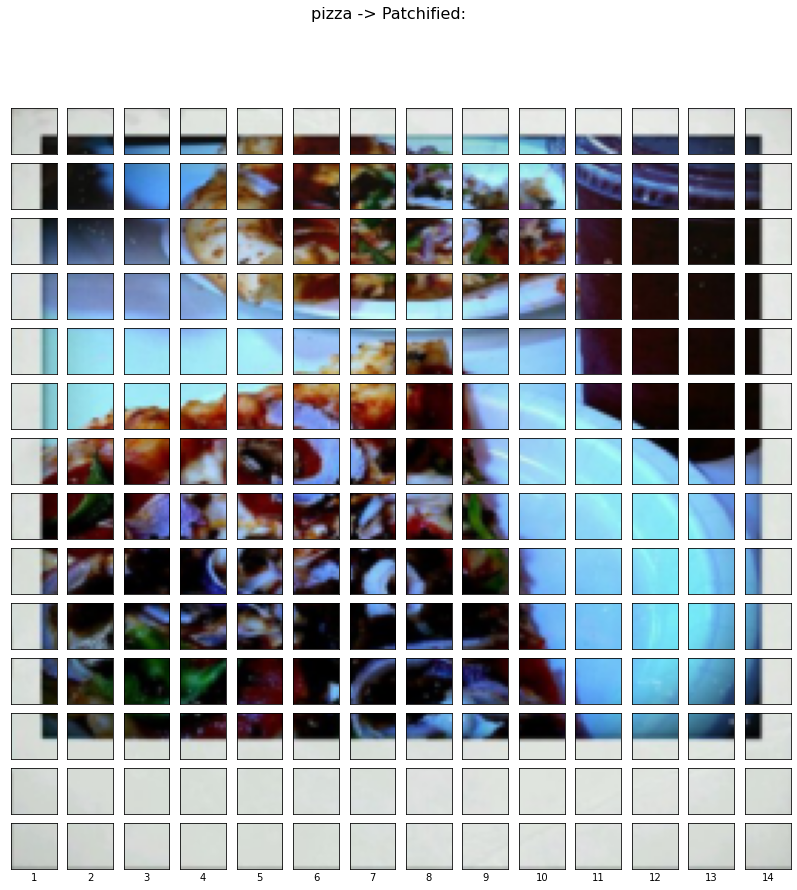

In [15]:
# Setup hyperparameters andmake sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")
# Create a series of subplots

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    
    # Plot the permuted image path 
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :]) # get all color channels
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified:", fontsize=16)
plt.show()


In [16]:
from torch import nn 

patch_size = 16

# Create the Conv2D layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Tabel 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could alse use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

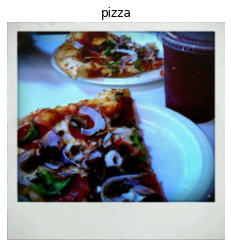

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


## Visualize five random feature maps

showing random convolutional feature maps from indexes: [357, 700, 68, 266, 432]


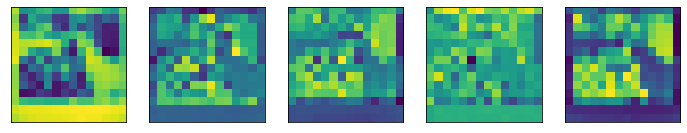

In [19]:
# Plot random 5 convolutional feature maps
import random 
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers
print(f"showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps

for i , idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
# Get a single feature map in tensor form

single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.6732,  0.6281,  0.5751,  0.5763,  0.7088,  0.6602,  0.7035,
            0.8732,  0.8433,  0.8339,  0.7228,  0.7544,  0.6692,  0.7094],
          [ 0.4443,  0.1327,  0.6215,  0.6308,  0.0477,  0.1677,  0.2087,
            0.3701,  0.6154,  0.7337,  0.4255,  0.3055,  0.2208,  0.6978],
          [ 0.5531,  0.2811,  0.3976,  0.4434,  0.3185,  0.2714,  0.1337,
            0.2670,  0.1062,  0.2997,  0.1407,  0.0420,  0.0263,  0.6287],
          [ 0.7168,  0.6038,  0.6639,  0.6600,  0.4882,  0.3367,  0.4297,
            0.4400,  0.4830,  0.6608,  0.1269,  0.0496,  0.0340,  0.6390],
          [ 0.7832,  0.8147,  0.8339,  0.8583,  0.8319,  0.8390,  0.6903,
            0.5349,  0.7306,  0.7502,  0.2337,  0.0386,  0.0231,  0.6245],
          [ 0.7834,  0.7916,  0.7178,  0.6507,  0.5592,  0.5056,  0.3746,
            0.0351,  0.6846,  0.8117,  0.3070,  0.0327,  0.0078,  0.6298],
          [ 0.6401,  0.1463,  0.2081,  0.2233,  0.1525,  0.5790,  0.3361,
           -0.0234,  0.5551,  0.

## Flattening the patch embedding with `torch.nn.Flatten()`

* **Desired output (1D sequence of flattened 2D patches)**: (196, 768)

In [21]:
# Current tensor shape

print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width")


Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width


In [22]:
# Create flatten layer

flatten = nn.Flatten(start_dim=2, # flatten feature_map_height
                     end_dim=3) # flatten feature_map_width

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


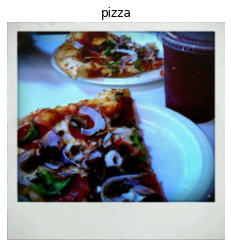

In [23]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatten the feature maps

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2*C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 768, 196]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

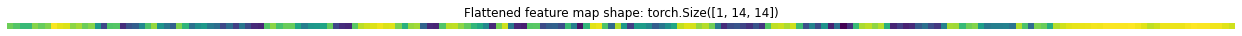

In [25]:
# Get a single flattened feature map

single_flattened_feature_map = image_out_of_conv_reshaped[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_feature_map.shape}")
plt.axis(False)

In [26]:
# See the flattened feature map as tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.6732,  0.6281,  0.5751,  0.5763,  0.7088,  0.6602,  0.7035,  0.8732,
           0.8433,  0.8339,  0.7228,  0.7544,  0.6692,  0.7094,  0.4443,  0.1327,
           0.6215,  0.6308,  0.0477,  0.1677,  0.2087,  0.3701,  0.6154,  0.7337,
           0.4255,  0.3055,  0.2208,  0.6978,  0.5531,  0.2811,  0.3976,  0.4434,
           0.3185,  0.2714,  0.1337,  0.2670,  0.1062,  0.2997,  0.1407,  0.0420,
           0.0263,  0.6287,  0.7168,  0.6038,  0.6639,  0.6600,  0.4882,  0.3367,
           0.4297,  0.4400,  0.4830,  0.6608,  0.1269,  0.0496,  0.0340,  0.6390,
           0.7832,  0.8147,  0.8339,  0.8583,  0.8319,  0.8390,  0.6903,  0.5349,
           0.7306,  0.7502,  0.2337,  0.0386,  0.0231,  0.6245,  0.7834,  0.7916,
           0.7178,  0.6507,  0.5592,  0.5056,  0.3746,  0.0351,  0.6846,  0.8117,
           0.3070,  0.0327,  0.0078,  0.6298,  0.6401,  0.1463,  0.2081,  0.2233,
           0.1525,  0.5790,  0.3361, -0.0234,  0.5551,  0.8408,  0.8568,  0.6176,
           0.249

## Turning the ViT patch embedding layer into a Pytorch module

In [27]:
# Create a class which subclasses nn.Module

class PatchEmbedding(nn.Module):
  """
  Turns a 2D input image into a 1D sequence learnable embedding vector.

  Args:
  in_channels (int): Number of color channels for the input images. Default to 3.
  patch_size (int): Size of patches to convert input image into . Default to 16.
  embedding_dim (int): Size of embedding to turn image into. Default to 768.
  """

  # Initialize the class with appropiate variabels

  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    # Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    
    # Create a layer to flatten to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)


    #  Define the forward
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch_size {patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension

In [28]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [29]:
# Create random input size
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

## Creating the class token embedding

In [30]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.5445,  0.1859, -0.1850,  ...,  0.3771, -0.3880,  0.3585],
         [-0.8277,  0.3368,  0.0065,  ...,  0.3208, -0.4639,  0.0745],
         [-0.8661,  0.4117, -0.1147,  ...,  0.4489, -0.4779,  0.0623],
         ...,
         [-0.8510,  0.2358, -0.2054,  ...,  0.6921, -0.4211,  0.3123],
         [-0.8347,  0.2261, -0.2021,  ...,  0.6741, -0.4103,  0.3058],
         [-0.8070,  0.2161, -0.1987,  ...,  0.6568, -0.4042,  0.3014]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [31]:
# get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # set learnable

# Show first 10 exampkles of class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepend shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5445,  0.1859, -0.1850,  ...,  0.3771, -0.3880,  0.3585],
         [-0.8277,  0.3368,  0.0065,  ...,  0.3208, -0.4639,  0.0745],
         ...,
         [-0.8510,  0.2358, -0.2054,  ...,  0.6921, -0.4211,  0.3123],
         [-0.8347,  0.2261, -0.2021,  ...,  0.6741, -0.4103,  0.3058],
         [-0.8070,  0.2161, -0.1987,  ...,  0.6568, -0.4042,  0.3014]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepend shape: torch.Size([1, 197, 768]) -> [batch_size, number_patches, embedding_dimension]


## Creating the position embedding

In [33]:
# View the sequence of patch embeddings with the pretended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5445,  0.1859, -0.1850,  ...,  0.3771, -0.3880,  0.3585],
          [-0.8277,  0.3368,  0.0065,  ...,  0.3208, -0.4639,  0.0745],
          ...,
          [-0.8510,  0.2358, -0.2054,  ...,  0.6921, -0.4211,  0.3123],
          [-0.8347,  0.2261, -0.2021,  ...,  0.6741, -0.4103,  0.3058],
          [-0.8070,  0.2161, -0.1987,  ...,  0.6568, -0.4042,  0.3014]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))

In [34]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension 
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10,:10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [35]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4555, 1.1859, 0.8150,  ..., 1.3771, 0.6120, 1.3585],
         [0.1723, 1.3368, 1.0065,  ..., 1.3208, 0.5361, 1.0745],
         ...,
         [0.1490, 1.2358, 0.7946,  ..., 1.6921, 0.5789, 1.3123],
         [0.1653, 1.2261, 0.7979,  ..., 1.6741, 0.5897, 1.3058],
         [0.1930, 1.2161, 0.8013,  ..., 1.6568, 0.5958, 1.3014]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Putting it all together: from image to embedding

In [36]:
set_seeds()


# Set patch size
patch_size = 16

# Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) 

print(f"Class token embedding shape: {class_token.shape}")

# Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                                  requires_grad=True)

# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# Multi - Head Attension(MSA)

In [37]:
# Create  a class that inherits from nn.Module
class MultiheadSelfAttenstionBlock(nn.Module):
  """Creates a multihead self-attention block (MSA block for short)
  """

  # Initialize the class with hyperameters from Table 1
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,
               attn_dropout: float=0):
   super().__init__()

   # Create the NormLayer(LN)
   self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

   # Create the Multi-Head Attention (MSA) layer
   self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                               num_heads=num_heads,
                                               dropout=attn_dropout,
                                               batch_first=True)
  
  # Create forward() method to pass the data through the layers
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)
    return attn_output

In [38]:
from torch.nn.modules.activation import MultiheadAttention
# Create an instance of MSABlock

multihead_self_attention_block = MultiheadSelfAttenstionBlock(embedding_dim=768,
                                                              num_heads=12)

# Pass patch and position image embedding through MSABlock

patched_image_throught_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_throught_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


# Multilayer Perceptron(MLP)

In [39]:
# Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
  """Creates a layer normalized mulitlayer perceptron block (MLP Block)
  """

  def __init__(self,
               embedding_dim: int=768,
               mlp_size: int=3072,
               dropout: float=0.1):
    super().__init__()

    # Create the Norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create Multilayer Perceptron (MLP)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)

    )

    # Create a forward() method to pass the data through the layers
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    
    return x

In [40]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of MSABlock 
patched_image_throught_mlp_block = mlp_block(patched_image_throught_msa_block)
print(f"Input shape: {patched_image_throught_msa_block.shape}")
print(f"Output shape: {patched_image_throught_mlp_block.shape}")

Input shape: torch.Size([1, 197, 768])
Output shape: torch.Size([1, 197, 768])


# Create Transformer Encoder Encoder

## Creating a Transformer Encoder by combining custom made layers

In [41]:
# Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
  """Creates a Transformer Encoder block
  """
  # Initialize the class with hyperparams 
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,
               mlp_size: int=3072,
               mlp_dropout: float=0.1,
               attn_dropout: float=0):
    super().__init__()

    # Create MSA Block
    self.msa_block = MultiheadSelfAttenstionBlock(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attn_dropout=attn_dropout)
    
    # Create MLP Block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
  # Create forward() method  
  def forward(self, x):

    # Create residual connection for MSA Block (add the input to the output)
    x = self.msa_block(x) + x 

    # Create residual connection for MLP Block (add the input to the output)
    x = self.mlp_block(x) + x 

    return x

In [42]:
# Create an instance of TransformerEncoedrBlock
transformer_encoder_block = TransformerEncoderBlock()

## Creating a Transformer Encoeder with Pytorch Transformer layers

In [43]:
# Create the same as above with torch.nn.TransformerEncoderLayer()

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size Dimension (D)
                                                             nhead=12, 
                                                             dim_feedforward=3072, # MLP size
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True, # Batch first in shape
                                                             norm_first=True)  # Normalize first or after MSA/MLP layers

torch_transformer_encoder_layer


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

# Putting it all together to create Vit

In [44]:
from torch.nn.modules.transformer import TransformerEncoderLayer
# Create a Vit class that inherits from nn.Module
class ViT(nn.Module):
  """
  Creates a Vision Transformer architecture 
  with ViT-Base hyperparameters by default
  """

  # Initalize the class with hyperparams 
  def __init__(self,
               img_size: int=224,
               in_channels: int=3,
               patch_size: int=16,
               num_transformer_layers: int=12,
               embedding_dim: int=768,
               mlp_size: int=3072,
               num_heads: int=12,
               attn_dropout: float=0,
               mlp_dropout: float=0.1,
               embedding_dropout: float=0.1,
               num_classes: int=1000): # Default for ImageNet, but will be changed later

    super().__init__()

    # check tha image size is divisble by the patch_size
    assert img_size % patch_size == 0

    # Calculate number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (need 1D sequence of patches)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
    
    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                           requires_grad=True)
    
    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    
    # Create Transformer Encoder blocks (we can Transformer Encoder blocks using nn.Sequnetial)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )
    # Create a forward() method

  def forward(self, x):
    
    # Get batch_size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Create patch embedding 

    x = self.patch_embedding(x)

    # Concat class embedding and patch embedding
    x = torch.cat((class_token, x), dim=1)

    # Add position embedding to patch embedding
    x = self.position_embedding + x

    # Run embedding dropout
    x = self.embedding_dropout(x)

    #Pass patch, position and class embedding through trasnformer encoder layers
    x = self.transformer_encoder(x)

    # Put 0 index logit through classifier
    x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

    return x
  

In [45]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [46]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes 
vit = ViT(num_classes=len(class_names))

# Pass the random tensor to ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

# Setting up training code for our ViT model

## Creating optimizer and  a loss function
## Training ViT model

In [51]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.003,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)
# Setup the loss function for multiclass classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds
set_seeds()

# train model

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1948 | train_acc: 0.3633 | test_loss: 5.1218 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9518 | train_acc: 0.3320 | test_loss: 1.6203 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7584 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2244 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


## Plot loss curves

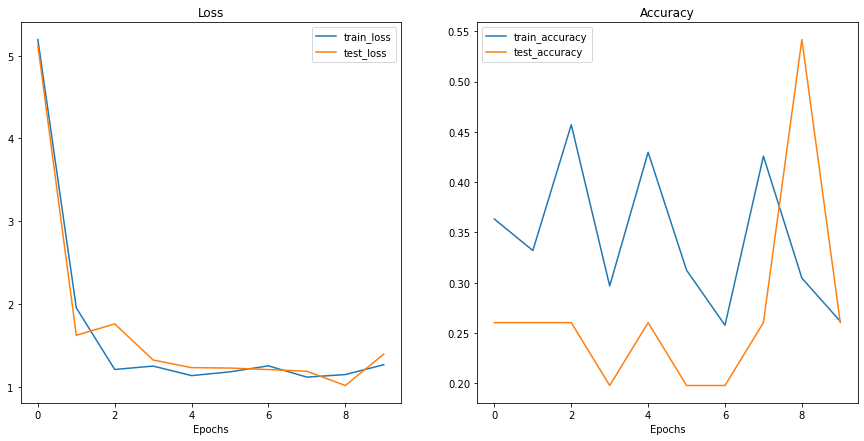

In [52]:
from helper_functions import plot_loss_curves
# Plot ViT model's curves

plot_loss_curves(results)

# Using a pretrained ViT from `torchvision.models` on the same dataset

In [53]:
import torch
import torchvision 
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [55]:
# Get predtrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Change the classifier head 
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Preparing data for the pretrained ViT model

In [56]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [57]:
# Setup train and test directory paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [58]:
# Get automatic tarnsforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [59]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

## Train feature extractor ViT model


In [60]:
from going_modular import engine

# Create optimizer and loss functions
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head 

set_seeds()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


## Plot loss curves

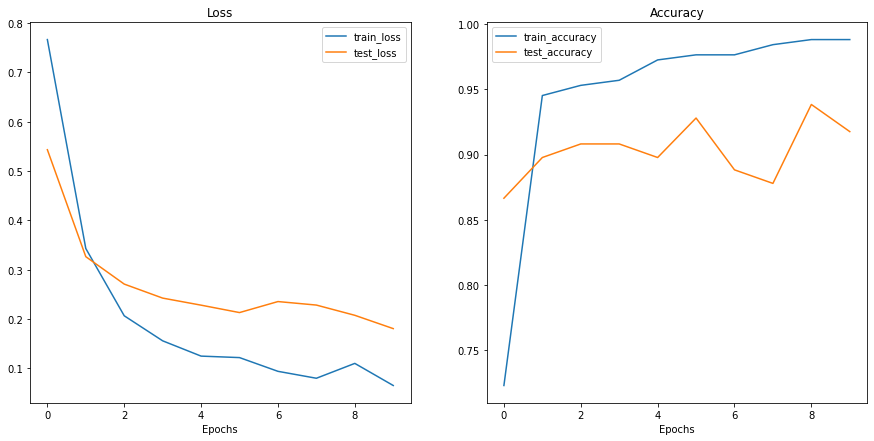

In [61]:
from helper_functions import plot_loss_curves 

plot_loss_curves(pretrained_vit_results)

## Save model

In [62]:
# Save the model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [63]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


# Make predictions on custom image 

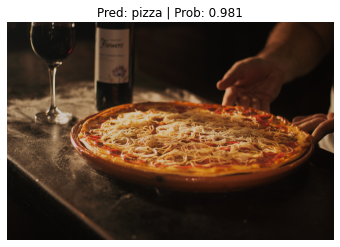

In [65]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.predictions import pred_and_plot_image

# setup custom image path
custom_image_path = image_path / 'pexels-edward-eyer-1049626.jpg'

# Donwload the image if it doesn't already exists
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get("https://github.com/Azamat0315277/pytorch_paper_replicating_for_computer_vision/raw/main/data/pexels-edward-eyer-1049626.jpg") 
    print(f"Downloading {custom_image_path} ...")
    f.write(request.content)
else:
  print(f"{custom_image_path} aleready exits, skipping download.")

# Predict on custom image

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)